# Fine-Tuning Without Context
Note: some of the cell below cannot be run because you do not have the access to the wandb projects.

In [1]:
import wandb
from pprint import pprint

import gym
import d4rl
import pickle
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import lfilter

from tqdm.notebook import tqdm

No module named 'flow'
No module named 'carla'
pybullet build time: Mar  7 2022 18:18:14


In [2]:
sns.set_style("ticks")
sns.set_context("paper", 1.5, {"lines.linewidth": 2})

# Utility Functions

In [12]:
def get_random_expert_score(env_name, path_to_dataset):
    """Get scores of random and expert datasets.

    Args:
        env_name (str): 'hopper', 'halfcheetah', or 'walker2d'.
        path_to_dataset (str): Path to D4RL dataset.

    Raises:
        NotImplementedError: only environments above are allowed.

    Returns:
        dict: {'random': random_score, 'expert: expert_score}
    """    
    return_map = {}
    datasets = ["random", "expert"]
    for dataset in datasets:

        if env_name == "hopper":
            env = gym.make("Hopper-v3")
        elif env_name == "halfcheetah":
            env = gym.make("HalfCheetah-v3")
        elif env_name == "walker2d":
            env = gym.make("Walker2d-v3")
        elif env_name == "reacher2d":
            from decision_transformer.envs.reacher_2d import Reacher2dEnv

            env = Reacher2dEnv()
        else:
            raise NotImplementedError

        state_dim = env.observation_space.shape[0]
        act_dim = env.action_space.shape[0]

        # load dataset
        dataset_path = f"{path_to_dataset}/{env_name}-{dataset}-v2.pkl"
        with open(dataset_path, "rb") as f:
            trajectories = pickle.load(f)

        # save all path information into separate lists
        mode = "normal"
        states, traj_lens, returns = [], [], []
        for path in trajectories:
            if mode == "delayed":  # delayed: all rewards moved to end of trajectory
                path["rewards"][-1] = path["rewards"].sum()
                path["rewards"][:-1] = 0.0
            states.append(path["observations"])
            traj_lens.append(len(path["observations"]))
            returns.append(path["rewards"].sum())
        traj_lens, returns = np.array(traj_lens), np.array(returns)

        # used for input normalization
        states = np.concatenate(states, axis=0)

        num_timesteps = sum(traj_lens)

        print("=" * 50)
        print(f"Starting new experiment: {env_name} {dataset}")
        print(f"{len(traj_lens)} trajectories, {num_timesteps} timesteps found")
        print(f"Average return: {np.mean(returns):.2f}, std: {np.std(returns):.2f}")
        print(f"Max return: {np.max(returns):.2f}, min: {np.min(returns):.2f}")
        print("=" * 50)
        
        if dataset == 'random':
            return_map['random'] = np.mean(returns)
        elif dataset == 'expert':
            return_map['expert'] = np.mean(returns)
    return return_map

def get_return_from_wandb(model_name, env_name, seed, block_id=None):
    """Get mean return from wandb

    Args:
        model_name (str): 'gpt2', 'igpt', or 'dt'.
        env_name (str): 'hopper', 'halfcheetah', or 'walker2d'.
        seed (int): Random seed used for the experiment.
        block_id (int, optional): From 0 to 11 for block replacement exp else None. Defaults to None.

    Returns:
        if block_id is not None:
            tuple[list, list]: mean return over epocs for K=1 and K=20.
        else:
            list:  mean return over epocs for K=1
    """    
    wand_project_name = 'your_wandb_project_name'
    api = wandb.Api()
    runs = api.runs(
        path=wand_project_name  # filters={'state':'finished'}
        )

    if env_name == 'hopper':
        rtg_conditioning = 3600
    elif env_name == 'halfcheetah':
        rtg_conditioning = 6000
    elif env_name == 'walker2d':
        rtg_conditioning = 5000
    else:
        rtg_conditioning = None

    if block_id is not None:
        for run in runs:
            if run.name == f'gym-experiment-{env_name}-medium-dt-{seed}-K1-block{block_id}':
                break
        return_mean_K1 = run.history()[f'evaluation/target_{rtg_conditioning}_return_mean']
        return return_mean_K1
    else:
        for run in runs:
            if run.name == f'gym-experiment-{env_name}-medium-{model_name}-{seed}-K1':
                break

        return_mean_K1 = run.history()[f'evaluation/target_{rtg_conditioning}_return_mean']

        for run in runs:
            if run.name == f'gym-experiment-{env_name}-medium-{model_name}-{seed}':
                break

        return_mean_K20 = run.history()[f'evaluation/target_{rtg_conditioning}_return_mean']

        return return_mean_K1, return_mean_K20


def get_action_error_from_wandb(model_name, env_name, seed, block_id=None):
    """Get action errors.

    Args:
        model_name (str): 'gpt2', 'igpt', or 'dt'.
        env_name (str): 'hopper', 'halfcheetah', or 'walker2d'.
        seed (int): Random seed used for the experiment.
        block_id (int, optional): From 0 to 11 for block replacement exp else None. Defaults to None.

    Returns:
        if block_id is not None:
            tuple[list, list]: action errors over epocs for K=1 and K=20.
        else:
            list: action error over epocs for K=1
    """    
    wandb_project_name = 'your_wandb_project_name'
    api = wandb.Api()
    runs = api.runs(
        path=wandb_project_name  # filters={'state':'finished'}
        )

    if block_id is not None:
        for run in runs:
            if run.name == f'gym-experiment-{env_name}-medium-dt-{seed}-K1-block{block_id}':
                break
        action_error_K1 = run.history()[f'training/action_error']
        return action_error_K1
    else:
        for run in runs:
            if run.name == f'gym-experiment-{env_name}-medium-{model_name}-{seed}-K1':
                break

        action_error_K1 = run.history()[f'training/action_error']

        for run in runs:
            if run.name == f'gym-experiment-{env_name}-medium-{model_name}-{seed}':
                break

        action_error_K20 = run.history()[f'training/action_error']

        return action_error_K1, action_error_K20 
        

## Plot Mean Return

Starting new experiment: hopper random
45239 trajectories, 999996 timesteps found
Average return: 18.40, std: 17.45
Max return: 292.55, min: 2.93
Starting new experiment: hopper expert
1027 trajectories, 999494 timesteps found
Average return: 3511.36, std: 328.59
Max return: 3759.08, min: 1645.28
'gpt2-hopper-666'
{'expert': 3511.3577, 'medium': 2943.1178582791554, 'random': 18.398905}
Best Epoch: 28
Normalized Score: 83.73184944298809
'dt-hopper-666'
{'expert': 3511.3577, 'medium': 9.873573927231448, 'random': 18.398905}
Best Epoch: 1
Normalized Score: -0.24407190313995944


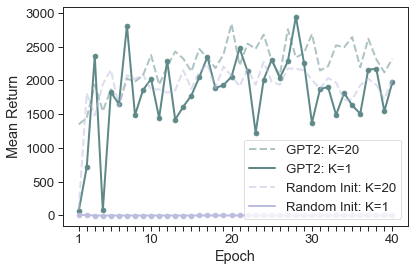

In [18]:
seed = 666
env_name = 'hopper'
model_name_list = ['gpt2', 'dt']
from_wandb = True
path_to_dataset = 'path_to_dataset'
path_to_return = 'path_to_save_return'
path_to_save_figure = 'path_to_save_figure'

return_map = get_random_expert_score(env_name, path_to_dataset)

for model_name in model_name_list:

    if from_wandb:
        return_mean_K1, return_mean_K20 = get_return_from_wandb(model_name, env_name, seed)
        np.save(f'{path_to_return}/returnmean_{model_name}_K1_{env_name}_medium_{seed}.npy', return_mean_K1)
        np.save(f'{path_to_return}/returnmean_{model_name}_K20_{env_name}_medium_{seed}.npy', return_mean_K20)
    else:
        return_mean_K1 = np.load(f'{path_to_return}/returnmean_{model_name}_K1_{env_name}_medium_{seed}.npy')
        return_mean_K20 = np.load(f'{path_to_return}/returnmean_{model_name}_K20_{env_name}_medium_{seed}.npy')

    return_map['medium'] = max(return_mean_K1)
    best_checkpoint_epoch = np.argmax(return_mean_K1) + 1
    normalized_score = 100 * (return_map['medium'] - return_map['random']) / (return_map['expert'] - return_map['random'])
    pprint(f'{model_name}-{env_name}-{seed}')
    pprint(return_map)
    print(f'Best Epoch: {best_checkpoint_epoch}')
    print(f'Normalized Score: {normalized_score}')

    if model_name == 'gpt2':
        color = (0.372, 0.537, 0.537)
        label_K1 = 'GPT2: K=1'
        label_K20 = 'GPT2: K=20'
    elif model_name == 'dt':
        color = (0.733, 0.737, 0.870)
        label_K1 = 'Random Init: K=1'
        label_K20 = 'Random Init: K=20'
    else:
        color = None

    plt.plot(return_mean_K20, color=color, label=label_K20, linestyle='dashed', alpha=0.5)
    plt.plot(return_mean_K1, color=color, label=label_K1)
    plt.scatter(np.arange(len(return_mean_K1)), return_mean_K1, color=color)

labels = [str(i) if (i % 10 == 0) or (i == 1) else ' ' for i in range(1, 41)]
plt.xticks(ticks=np.arange(0, 40), labels=labels)
plt.legend(loc='lower right')
plt.ylabel('Mean Return')
plt.xlabel('Epoch')
plt.tight_layout()
plt.savefig(f'{path_to_save_figure}/returnmean_gpt2_dt_K1_{env_name}_medium_{seed}.pdf')
plt.show()
    

## Block Replacement

In [3]:
sns.set_palette("hls", 12)
def ema(x, alpha):
    zi = [x[0]]
    y, zi = lfilter([1.-alpha], [1., -alpha], x, zi=zi)
    return y

### Mean Return

  0%|          | 0/12 [00:00<?, ?it/s]

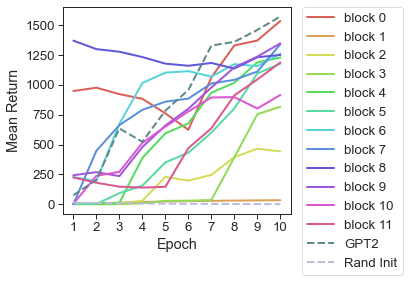

In [9]:
seed = 666
env_name = 'hopper'
model_name_list = ['gpt2', 'dt']
block_id_list = np.arange(12)
early_epoch = {'hopper': 10, 'halfcheetah': 5, 'walker2d': 5}
smooth_const = 0.8
colors = {'gpt2': (0.372, 0.537, 0.537), 'dt': (0.733, 0.737, 0.870)}
labels = {'gpt2': 'GPT2', 'dt': 'Rand Init'}
from_wandb = True
path_to_return = 'path_to_return'
path_to_save_figure = 'path_to_save_figure'

for block_id in tqdm(block_id_list):

    if from_wandb:
        return_mean_K1_block = get_return_from_wandb('dt', env_name, seed, block_id=block_id)
        np.save(f'{path_to_return}/returnmean_dt_K1_block{block_id}_{env_name}_medium_{seed}.npy', return_mean_K1_block)
        return_mean_K1_block = return_mean_K1_block[:early_epoch[env_name]]
    else:
        return_mean_K1_block = np.load(f'{path_to_return}/returnmean_dt_K1_block{block_id}_{env_name}_medium_{seed}.npy')[:early_epoch[env_name]]

    plt.plot(ema(return_mean_K1_block, smooth_const), label=f'block {block_id}')


for model_name in model_name_list:

    if from_wandb:
        return_mean_K1, _ = get_return_from_wandb(model_name, env_name, seed)
        np.save(f'{path_to_return}/returnmean_{model_name}_K1_{env_name}_medium_{seed}.npy', return_mean_K1)
        return_mean_K1 = return_mean_K1[:early_epoch[env_name]]
    else:
        return_mean_K1 = np.load(f'{path_to_return}/returnmean_{model_name}_K1_{env_name}_medium_{seed}.npy')[:early_epoch[env_name]]

    plt.plot(ema(return_mean_K1, smooth_const), color=colors[model_name], label=labels[model_name], linestyle="dashed")

ticks_labels = [str(i) for i in range(1, early_epoch[env_name] + 1)]
plt.xticks(ticks=np.arange(0, early_epoch[env_name]), labels=ticks_labels)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.ylabel('Mean Return')
plt.xlabel('Epoch')
plt.tight_layout()
plt.savefig(f'{path_to_save_figure}/returnmean_block_gpt2_dt_K1_{env_name}_medium_{seed}.pdf')
plt.show()
    

### Action Error

  0%|          | 0/12 [00:00<?, ?it/s]

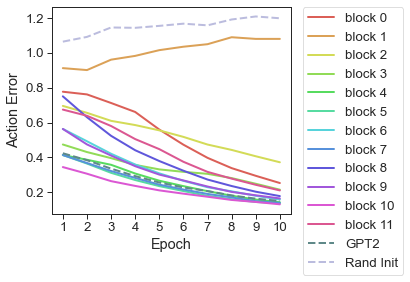

In [13]:
seed = 666
env_name = 'hopper'
model_name_list = ['gpt2', 'dt']
block_id_list = np.arange(12)
early_epoch = {'hopper': 10, 'halfcheetah': 5, 'walker2d': 5}
smooth_const = 0.8
colors = {'gpt2': (0.372, 0.537, 0.537), 'dt': (0.733, 0.737, 0.870)}
labels = {'gpt2': 'GPT2', 'dt': 'Rand Init'}
from_wandb = True
path_to_action_error = 'path_to_action_error'
path_to_save_figure = 'path_to_save_figure'

for block_id in tqdm(block_id_list):

    if from_wandb:
        action_error_K1_block = get_action_error_from_wandb('dt', env_name, seed, block_id=block_id)
        np.save(f'{path_to_action_error}/actionerror_dt_K1_block{block_id}_{env_name}_medium_{seed}.npy', action_error_K1_block)
        action_error_K1_block = action_error_K1_block[:early_epoch[env_name]]
    else:
        action_error_K1_block = np.load(f'{path_to_action_error}/actionerror_dt_K1_block{block_id}_{env_name}_medium_{seed}.npy')[:early_epoch[env_name]]

    plt.plot(ema(action_error_K1_block, smooth_const), label=f'block {block_id}')


for model_name in model_name_list:

    if from_wandb:
        action_error_K1, _ = get_action_error_from_wandb(model_name, env_name, seed)
        np.save(f'{path_to_action_error}/actionerror_{model_name}_K1_{env_name}_medium_{seed}.npy', action_error_K1)
        action_error_K1 = action_error_K1[:early_epoch[env_name]]
    else:
        action_error_K1 = np.load(f'{path_to_action_error}/actionerror_{model_name}_K1_{env_name}_medium_{seed}.npy')[:early_epoch[env_name]]

    plt.plot(ema(action_error_K1, smooth_const), color=colors[model_name], label=labels[model_name], linestyle="dashed")

ticks_labels = [str(i) for i in range(1, early_epoch[env_name] + 1)]
plt.xticks(ticks=np.arange(0, early_epoch[env_name]), labels=ticks_labels)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.ylabel('Action Error')
plt.xlabel('Epoch')
plt.tight_layout()
plt.savefig(f'{path_to_save_figure}/actionerror_block_gpt2_dt_K1_{env_name}_medium_{seed}.pdf')
plt.show()
    